# Model creation (superresolution)

In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import tools.common_functions as cf
import tools.regression as reg

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
NR_SUBREGIONS = 2
DATA_NORMAL_FORCE_FILE = f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2"

# Automated
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]


In [2]:
# Load in data file and prepare for fitting
normal_force_df = cf.prepare_data_for_fitting(DATA_NORMAL_FORCE_FILE, ARRAY_SIZE, SENSOR_LAG )
normal_force_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35428 entries, 1 to 35428
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   35428 non-null  int64  
 1   t_wall  35428 non-null  float64
 2   X0      35428 non-null  float64
 3   Y0      35428 non-null  float64
 4   Z0      35428 non-null  float64
 5   X1      35428 non-null  float64
 6   Y1      35428 non-null  float64
 7   Z1      35428 non-null  float64
 8   X2      35428 non-null  float64
 9   Y2      35428 non-null  float64
 10  Z2      35428 non-null  float64
 11  X3      35428 non-null  float64
 12  Y3      35428 non-null  float64
 13  Z3      35428 non-null  float64
 14  F_x     35428 non-null  float64
 15  F_y     35428 non-null  float64
 16  F_z     35428 non-null  float64
 17  T_x     35428 non-null  float64
 18  T_y     35428 non-null  float64
 19  T_z     35428 non-null  float64
 20  X       35428 non-null  float64
 21  Y       35428 non-null  float64
 22

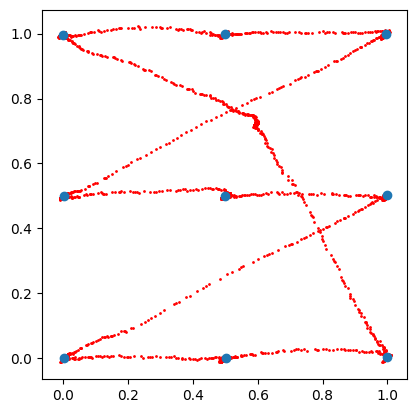

In [3]:
# Extract boundary points
center_points, normal_force_normalized_df = cf.extract_center_points_from_data(normal_force_df, ARRAY_SIZE_SUB, normalize=True) 

plt.scatter(normal_force_normalized_df['X'], normal_force_normalized_df['Y'],s=1, c='r')
plt.scatter(center_points[:,0], center_points[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

   level_0  index        t_wall        X0        Y0        Z0        X1  \
0     1764   7559  1.709910e+09 -0.002882 -0.002151 -0.007765 -0.003965   
1     1765    306  1.709910e+09 -0.002732 -0.001951 -0.007281 -0.004915   
2     1766   7560  1.709910e+09 -0.002032 -0.002251 -0.006878 -0.003815   
3     1767   7561  1.709910e+09 -0.001332 -0.002551 -0.006474 -0.002715   
4     1768   7562  1.709910e+09 -0.000632 -0.002851 -0.006071 -0.001615   

         Y1        Z1        X2  ...        Z3       F_x       F_y       F_z  \
0  0.000675  0.012475 -0.002182  ...  0.013632 -0.282262 -0.081010 -0.942149   
1  0.001425  0.013040 -0.001382  ...  0.013390 -0.353067 -0.032852 -0.966420   
2  0.000975  0.013443 -0.002282  ...  0.011776 -0.423872  0.015306 -0.990691   
3  0.000525  0.013846 -0.003182  ...  0.010163 -0.650235  0.033504 -0.914371   
4  0.000075  0.014250 -0.004082  ...  0.008550 -0.588631  0.058945 -0.957859   

        T_x       T_y       T_z         X         Y         Z  
0 -0

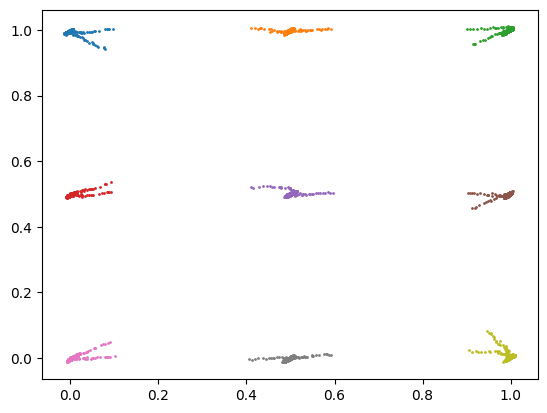

In [4]:
# Now split into the 4 regions used for fitting
regions_data = cf.split_data_into_regions(normal_force_df, center_points, min_distance=0.1)

for data in regions_data:
  print(data.head())
  plt.scatter(data['X'], data['Y'],s=1)
plt.show()

In [252]:
# Now fit the data per region (=taxel)
# Model: {X{i}, Y{i}, Z{i}} -> F_z{i}

normal_force_models_taxels = []

for region in regions_data:
  
  # Find largest activation 
  Z_measurements = region[[f'Z{i}' for i in range(ARRAY_SIZE)]]
  largest_activation_in_region_index = np.argmax(np.max(Z_measurements) - np.min(Z_measurements))
  
  print("Taxel {} has largest activation".format(largest_activation_in_region_index))
  
  X = region[[f'Z{largest_activation_in_region_index}']]
  y = region[['F_z']]
  
  # Fit
  model = reg.create_regression_pipeline_and_fit(X, y)
  model.activation_index = largest_activation_in_region_index
  
  normal_force_models_taxels.append(model)
  

Taxel 2 has largest activation
Score:  0.7617169581704175
MSE:  2.5404251538008493
Taxel 3 has largest activation
Score:  0.7673904333953868
MSE:  2.7203294017839954
Taxel 1 has largest activation
Score:  0.7669118007365696
MSE:  2.7567905151793646
Taxel 0 has largest activation
Score:  0.7742470348043695
MSE:  2.5137393076656007


/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/lowiek/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/lowiek/.local/lib/python3.10/site-pac

2
(3549, 1)


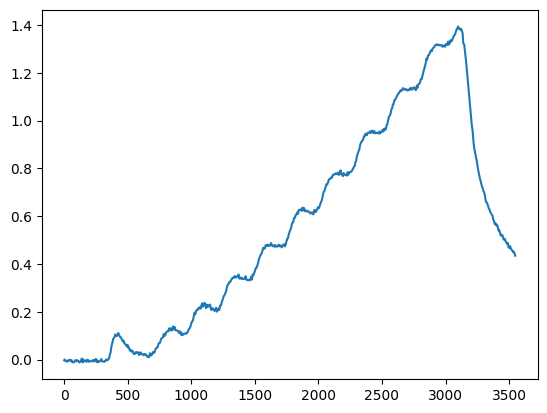

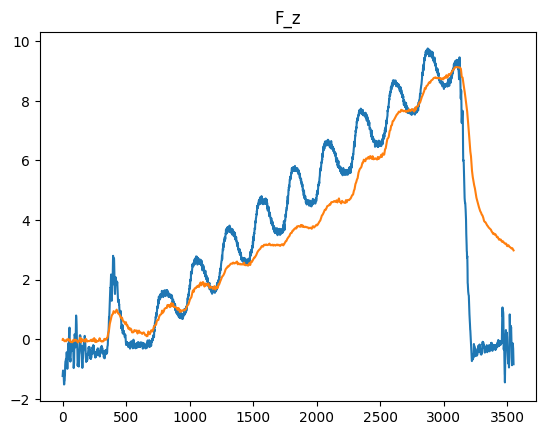

3
(3668, 1)


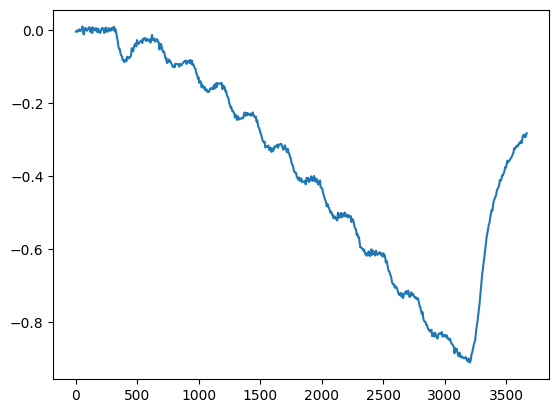

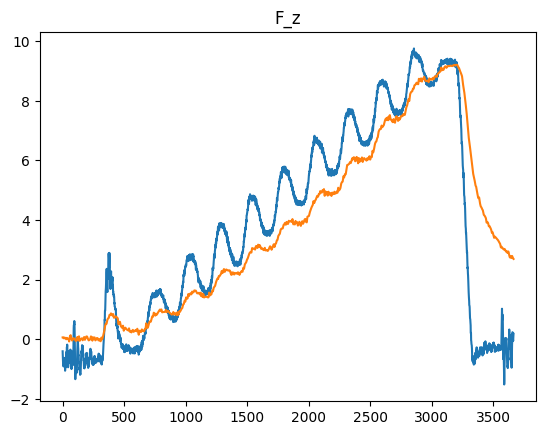

1
(3695, 1)


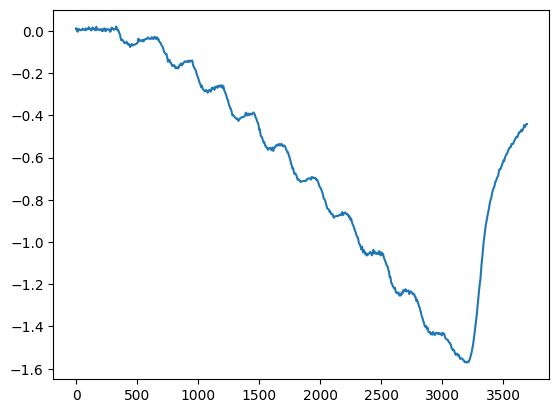

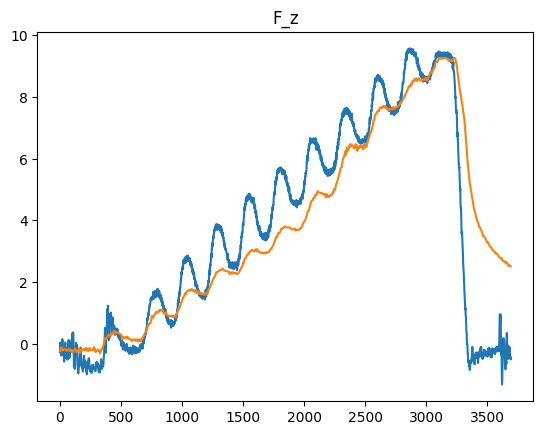

0
(3462, 1)


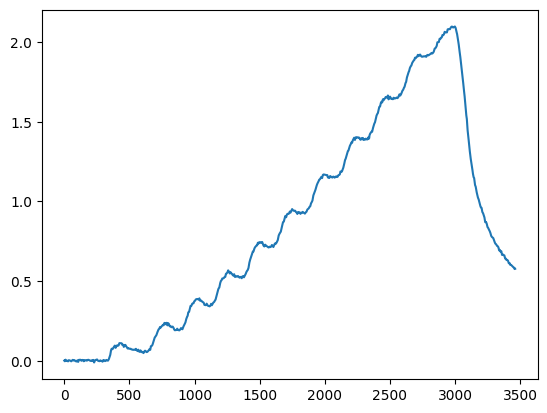

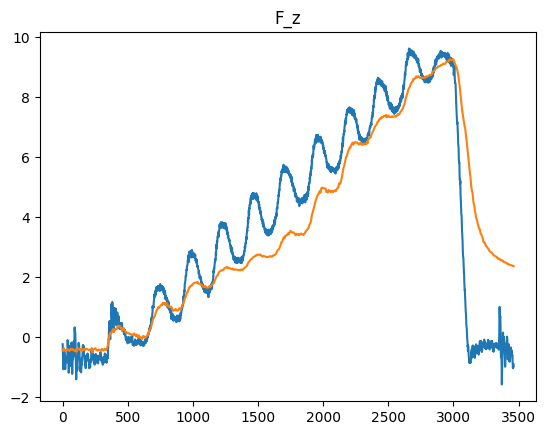

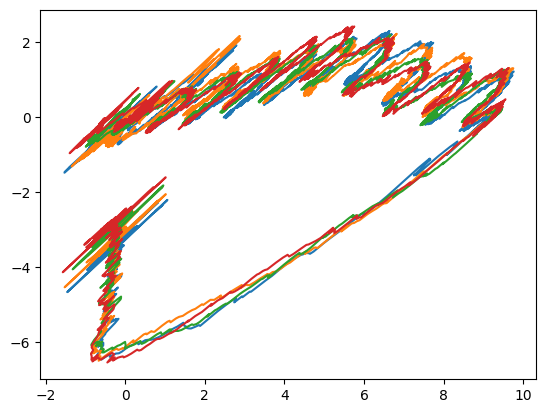

In [254]:
errors = []
indices = []

for model, region in zip(normal_force_models_taxels, regions_data):
  
  print(model.activation_index)
  indices.append(model.activation_index)
  
  # Predict
  Z_measurements = region[[f'Z{i}' for i in range(ARRAY_SIZE)]]
  X = region[[f'Z{model.activation_index}']]
  Y_pred = model.predict(X)
  
  print(Y_pred.shape)
  
  plt.plot(region[[f'Z{model.activation_index}']])
  plt.show()
  
  # Plot against actual
  for i, name in enumerate(['F_z']):
    plt.figure()
    plt.title(name)
    plt.plot(region[name])
    plt.plot(Y_pred)
    plt.show()
    
  # Calculate error
  errors.append(region[name].to_numpy() - Y_pred[:, 0])

  plt.show()
  
i = 0
for index, err in zip(indices, errors):
  
  plt.plot(regions_data[i][f'F_z'], err)
  i += 1

# Hysteresis testing


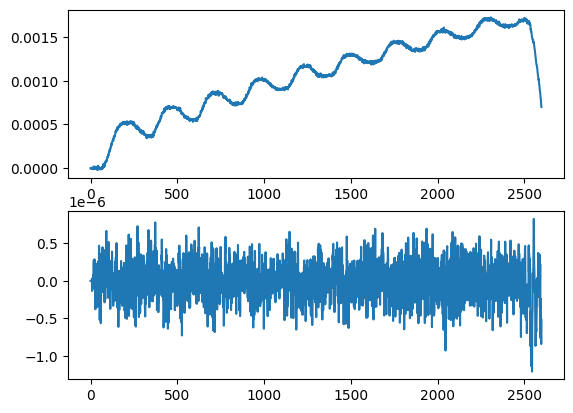

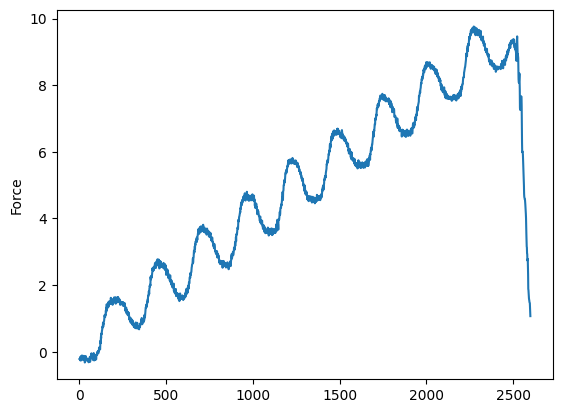

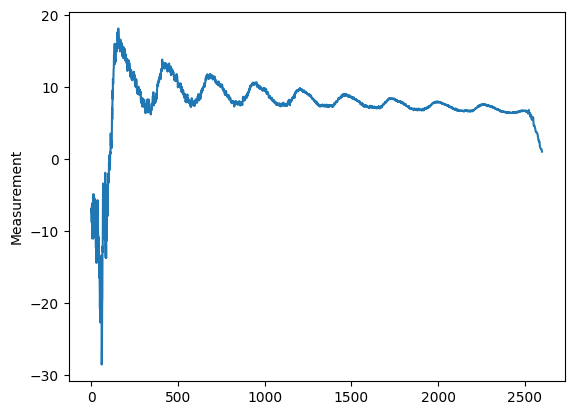

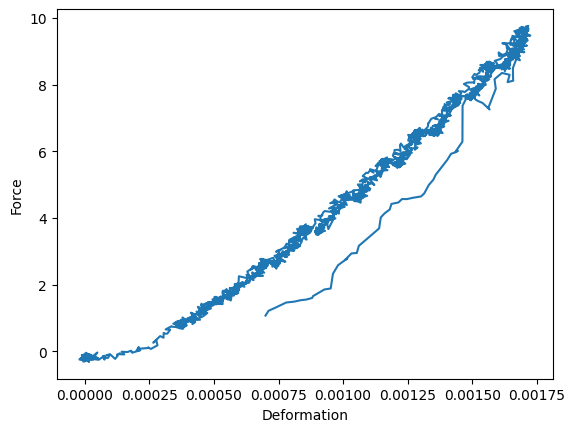

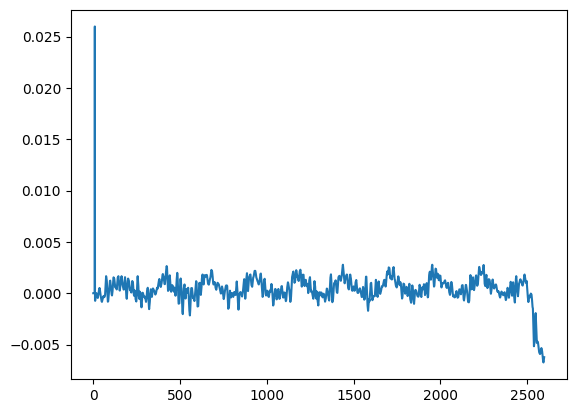

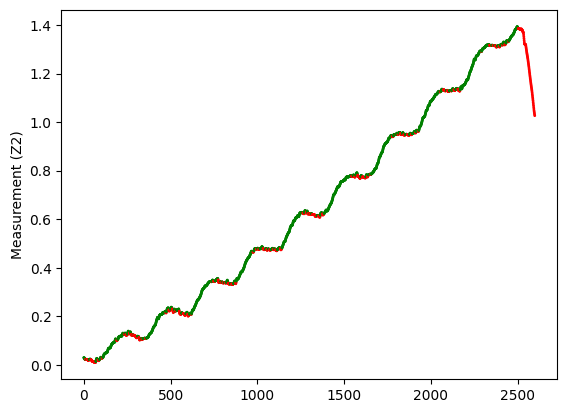

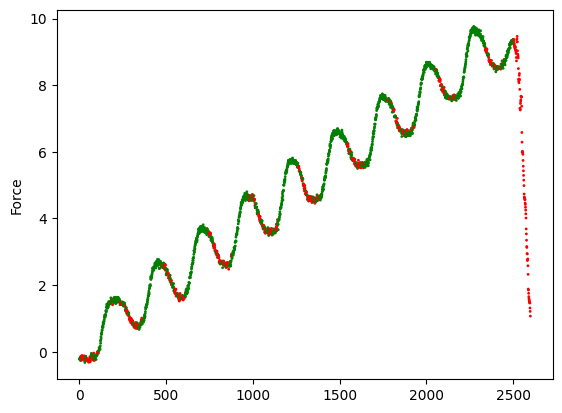

In [209]:
# Plot F_z vs normalized deformation
min_index = 600
max_index = 3200
data = regions_data[0].copy()[min_index:max_index]

z_data = data['Z'].to_numpy()
z_data -= z_data[0]
# if np.min(z_data) < 0:
z_data *= -1

measurements = data['Z2'].to_numpy()
output = data['F_z'].to_numpy()

def moving_average(x, w):
    return np.pad(np.convolve(x, np.ones(w), 'valid') / w, (w, 0), mode='constant')
  
differential = np.diff(moving_average(measurements, 10))
c = ['r' if d < 0 else 'g' for d in differential]

mask = differential > 0

fig, axs = plt.subplots(2)

axs[0].plot(z_data)
# plt.ylabel('Deformation')
# plt.show()

axs[1].plot(np.diff(moving_average(np.diff(moving_average(z_data, 10)), 10)))
# plt.ylabel('Deformation')
plt.show()

plt.plot(data['F_z'].to_numpy())
plt.ylabel('Force')
plt.show()
plt.plot(data['F_z'].to_numpy() / data['Z2'].to_numpy())
plt.ylabel('Measurement')
plt.show()
plt.plot(z_data, data['F_z'])
plt.xlabel('Deformation')
plt.ylabel('Force')
plt.show()

plt.plot(differential)
plt.show()

plt.scatter(range(len(measurements)), measurements, c=c, s=1)
plt.ylabel('Measurement (Z2)')
# plt.ylabel('Force')
plt.show()

plt.scatter(range(len(output)), output,  c=c, s=1)
plt.ylabel('Force')
plt.show()

In [210]:
def calculate_corrected_data(params):

  a, b, c, d = params

  pos_weights = np.linspace(a, b, len(measurements))
  neg_weights = np.linspace(c, d, len(measurements))

  corrected_measurements = np.zeros(len(measurements))

  for i in range(1, len(measurements)):
    if mask[i]:
      corrected_measurements[i] = corrected_measurements[i - 1] + differential[i] * pos_weights[i]
    else:
      corrected_measurements[i] = corrected_measurements[i - 1] + differential[i] * neg_weights[i]
      
  return corrected_measurements

In [211]:
a = np.linspace(13, 14.5, 10)
b = np.linspace(4, 6, 10)
c = np.linspace(17, 20, 10)
d = np.linspace(20, 100, 10)

MSEs = []
best_params = []
best_MSE = 999999999

for i in range(len(a)):
  for j in range(len(b)):
    for k in range(len(c)):
      for l in range(len(d)):
        corrected_measurements = calculate_corrected_data([a[i], b[j], c[k], d[l]])
        
        MSE = np.mean((corrected_measurements - output) ** 2)
        MSEs.append(MSE)
        
        if MSE < best_MSE:
          best_params = [a[i], b[j], c[k], d[l]]
          best_MSE = MSE
          
      else:
        continue
      break
    else:
      continue
    break
  else:
    continue
  break

[14.5, 6.0, 18.0, 37.77777777777778]


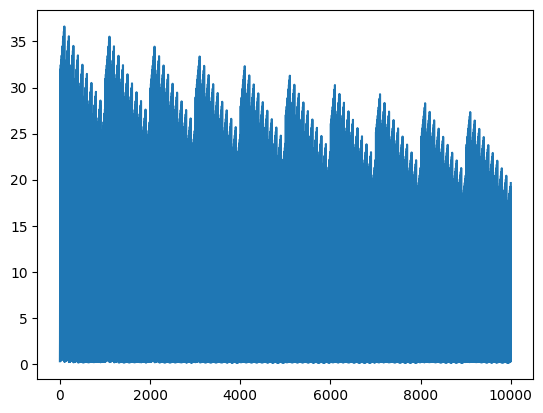

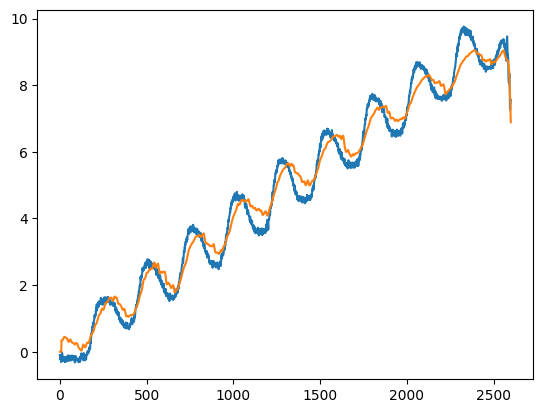

In [141]:
print(best_params)
plt.plot(MSEs)
plt.show()

corrected_measurements = calculate_corrected_data(best_params)
plt.plot(output)
plt.plot(corrected_measurements)

In [68]:
class Hysteron:
  
  def __init__(self, alpha, beta): # beta > alpha
    self.alpha = alpha
    self.beta = beta
    self.state = 0
    
  def update(self, measurement):
    
    if measurement > self.beta:
      self.state = 1
    elif measurement < self.alpha:
      self.state = 0
    
    return self.state
    

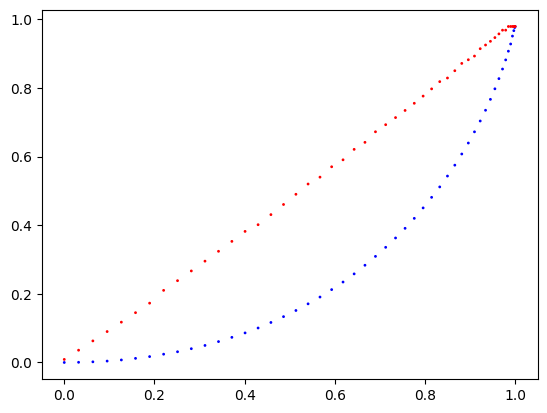

In [106]:
# Make hysterons with beta - alpha = step from 0 to 1 
step = 0.01

hysterons = []
for alpha in np.linspace(0, 1 - step, int(1/step)):
  for beta in np.linspace(alpha + step, 1, int(1/step)):
    hysterons.append(Hysteron(alpha, beta))

# Now plot the 

weights = np.linspace(0.9, 1.1, len(hysterons))
weights /= np.sum(weights)

X = np.sin(np.linspace(0, np.pi, 100))
y = np.zeros(100)

c = ['b' for i in range(50)] + ['r' for i in range(50)]

for i in range(len(X)):
  tmp = 0
  for j, hys in enumerate(hysterons):
    tmp += hys.update(X[i]) * weights[j]
    
  y[i] = tmp
  
plt.scatter(X, y, s=1,c=c)
  

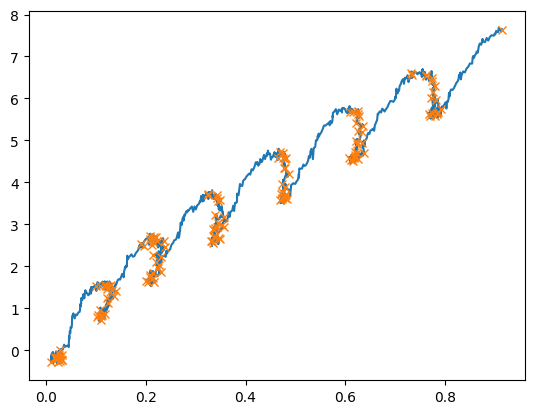

In [12]:
import hysteresis as hys

xy = np.column_stack([data['Z2'], data['F_z']])

myHys = hys.Hysteresis(xy)
myHys.plot(showReversals = True)

(1260, 2) (540, 2)


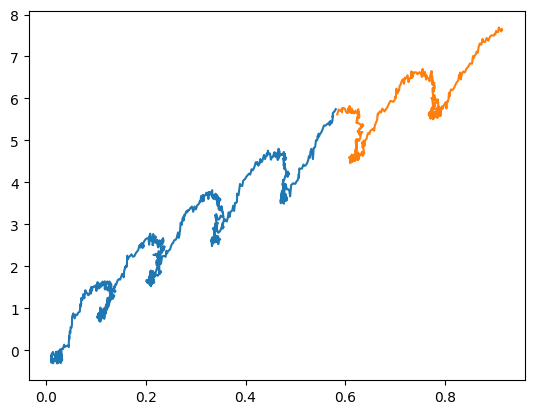

In [13]:
dataset = regions_data[0][['Z2', 'F_z']][min_index:max_index].copy()

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

print(train.shape, test.shape)

plt.plot(train['Z2'], train['F_z'])
plt.plot(test['Z2'], test['F_z'])

In [14]:
# Split the data
def create_dataset(dataset, nr_steps):
    dataX, dataY = [], []
    for i in range(dataset.shape[0] - nr_steps - 1):
        a = dataset[i:(i + nr_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + nr_steps, 1])
    return np.array(dataX), np.array(dataY)

n_steps = 50
features = 1

# split into samples
X_train, y_train = create_dataset(train.to_numpy(), n_steps)
X_test, y_test = create_dataset(test.to_numpy(), n_steps)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1209, 1, 50) (1209,)
(489, 1, 50) (489,)


Building an RNN

In [17]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

# Define LSTM model
model = Sequential()
# model.add(LSTM(64, return_sequences=True))  
model.add(LSTM(16))  
model.add(Dense(1, activation='relu'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer=Adam(0.01), loss=MeanSquaredError(), metrics=['accuracy'])


# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16)

Epoch 1/50


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 843us/step - accuracy: 0.0000e+00 - loss: 1.7873
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.0000e+00 - loss: 0.2780
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.0000e+00 - loss: 0.2501
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.0000e+00 - loss: 0.1971
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.0000e+00 - loss: 0.1235
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.0000e+00 - loss: 0.0765
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.0000e+00 - loss: 0.0411
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.0000e+00 - loss: 0.0408
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.0000e+00 - loss: 0.0323
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.0000e+00 - loss: 0.0336
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.0000e+00 - loss: 0.0284
Epoch 12/50
76/76 ━

In [22]:

# make predictions
trainPredict = model.predict(np.linspace(0, 0.6, 100).reshape(-1, 1, 1))
testPredict = model.predict(X_test)

print(trainPredict.shape)
print(testPredict.shape)

print(y_train.shape)
print(y_test.shape)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2024-03-16 22:19:44.778621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Matrix size-incompatible: In[0]: [32,1], In[1]: [50,64]
	 [[{{function_node sequential_2_1_lstm_2_1_while_body_37620}}{{node sequential_2_1/lstm_2_1/while/lstm_cell_1/MatMul}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_2_1/lstm_2_1/while/lstm_cell_1/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/lowiek/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/lowiek/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 978, in launch_instance

  File "/home/lowiek/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start

  File "/home/lowiek/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/lowiek/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/home/lowiek/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/home/lowiek/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/home/lowiek/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/home/lowiek/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/home/lowiek/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/home/lowiek/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell

  File "/home/lowiek/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell

  File "/home/lowiek/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/lowiek/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async

  File "/home/lowiek/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes

  File "/home/lowiek/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code

  File "/tmp/ipykernel_172262/1556541491.py", line 2, in <module>

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 513, in predict

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 212, in one_step_on_data_distributed

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 201, in one_step_on_data

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 93, in predict_step

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/models/sequential.py", line 203, in call

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/models/functional.py", line 188, in call

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/models/functional.py", line 572, in call

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 538, in call

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 397, in call

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 533, in inner_loop

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 339, in inner_loop

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 427, in rnn

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 412, in _step

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 331, in step

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 265, in call

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 3547, in matmul

  File "/home/lowiek/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 239, in matmul

Matrix size-incompatible: In[0]: [32,1], In[1]: [50,64]
	 [[{{node sequential_2_1/lstm_2_1/while/lstm_cell_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_37710]

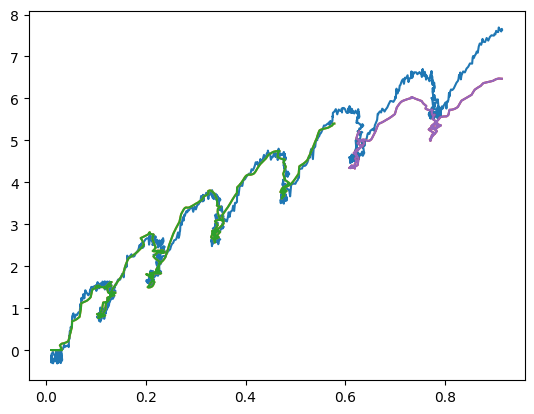

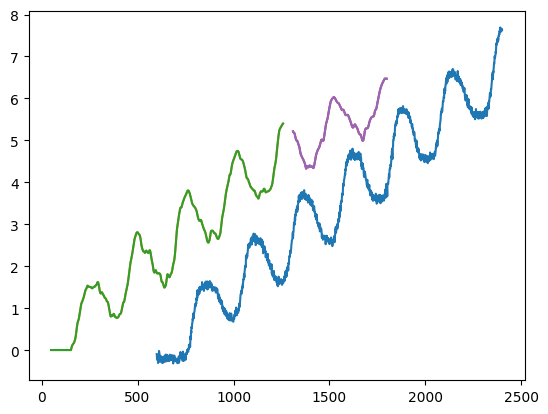

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps:len(trainPredict)+n_steps, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(n_steps*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset['Z2'], dataset['F_z'])
plt.plot(dataset['Z2'],trainPredictPlot)
plt.plot(dataset['Z2'],testPredictPlot)
# plt.plot(testPredictPlot)
plt.show()

plt.plot(dataset['F_z'])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

# Validation

In [307]:
# Validate against the subsampled version
# Load in data file and prepare for val
normal_force_df_val = cf.prepare_data_for_fitting(f"table_calibration/2x2_grid_subsampling_x2_08032024_schroef2", ARRAY_SIZE, SENSOR_LAG)
normal_force_df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35428 entries, 1 to 35428
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   35428 non-null  int64  
 1   t_wall  35428 non-null  float64
 2   X0      35428 non-null  float64
 3   Y0      35428 non-null  float64
 4   Z0      35428 non-null  float64
 5   X1      35428 non-null  float64
 6   Y1      35428 non-null  float64
 7   Z1      35428 non-null  float64
 8   X2      35428 non-null  float64
 9   Y2      35428 non-null  float64
 10  Z2      35428 non-null  float64
 11  X3      35428 non-null  float64
 12  Y3      35428 non-null  float64
 13  Z3      35428 non-null  float64
 14  F_x     35428 non-null  float64
 15  F_y     35428 non-null  float64
 16  F_z     35428 non-null  float64
 17  T_x     35428 non-null  float64
 18  T_y     35428 non-null  float64
 19  T_z     35428 non-null  float64
 20  X       35428 non-null  float64
 21  Y       35428 non-null  float64
 22

In [308]:
combined_model = reg.CombinedModel([normal_force_models_taxels[i] for i in [3, 2, 0, 1]])

['Z0' 'Z0^2' 'Z0^3' 'Z0^4' 'Z0^5' 'Z0^6' 'Z0^7' 'Z0^8' 'Z0^9' 'Z0^10'
 'Z0^11' 'Z0^12' 'Z0^13' 'Z0^14' 'Z0^15' 'Z0^16']
['Z1' 'Z1^2' 'Z1^3' 'Z1^4' 'Z1^5' 'Z1^6' 'Z1^7' 'Z1^8' 'Z1^9' 'Z1^10'
 'Z1^11' 'Z1^12' 'Z1^13' 'Z1^14' 'Z1^15' 'Z1^16']
['Z2' 'Z2^2' 'Z2^3' 'Z2^4' 'Z2^5' 'Z2^6' 'Z2^7' 'Z2^8' 'Z2^9' 'Z2^10'
 'Z2^11' 'Z2^12' 'Z2^13' 'Z2^14' 'Z2^15' 'Z2^16']
['Z3' 'Z3^2' 'Z3^3' 'Z3^4' 'Z3^5' 'Z3^6' 'Z3^7' 'Z3^8' 'Z3^9' 'Z3^10'
 'Z3^11' 'Z3^12' 'Z3^13' 'Z3^14' 'Z3^15' 'Z3^16']


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


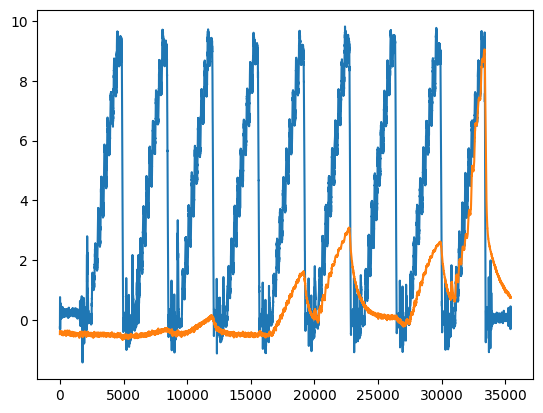

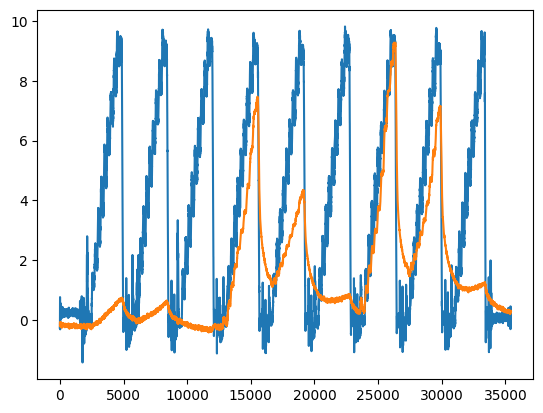

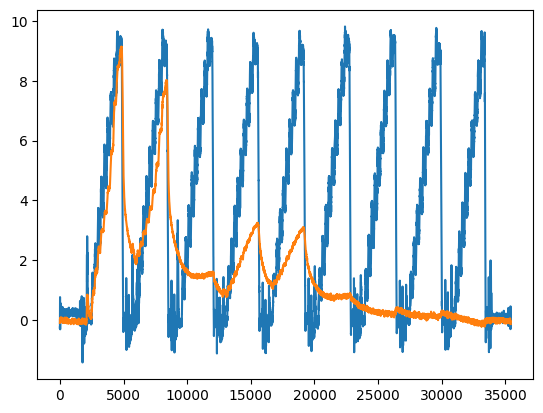

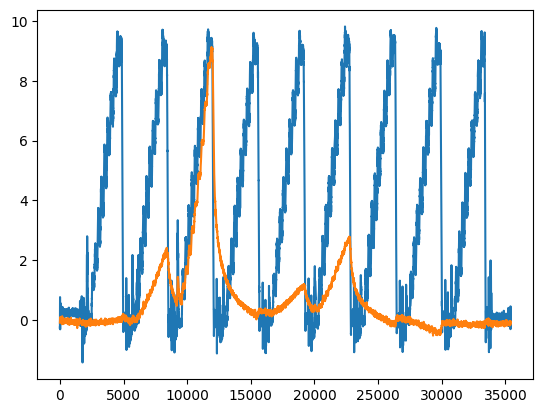

In [316]:
# Predict F_z{i} based on measurements
X = normal_force_df_val[[f'Z{i}' for i in range(ARRAY_SIZE)]].to_numpy()
F_zi = combined_model.predict(X)
for i in range(4):
  plt.plot(normal_force_df_val[f'F_z'])
  plt.plot(F_zi[:, i])
  plt.show()

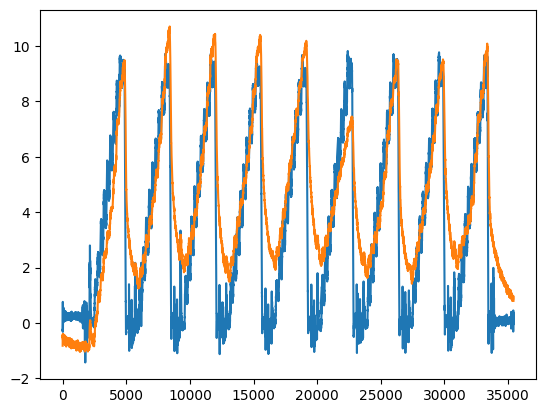

In [310]:
# Try to add them all up
plt.plot(normal_force_df_val['F_z'])
plt.plot(np.sum(F_zi, axis=1))


(35428, 4)
(35428,)
(35428,)


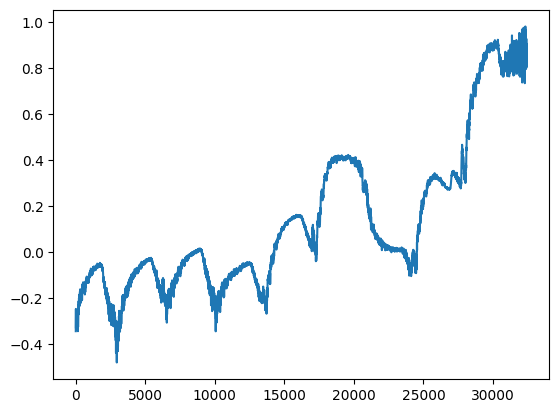

(35428,)


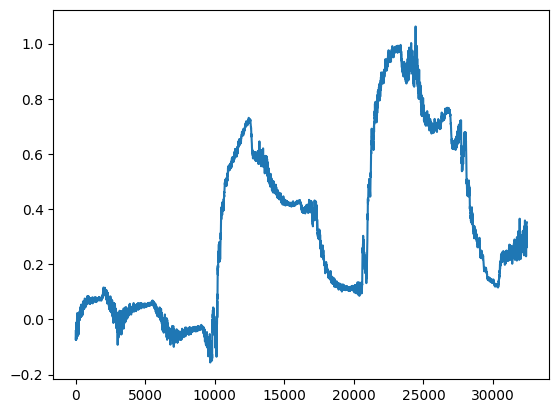

(35428,)


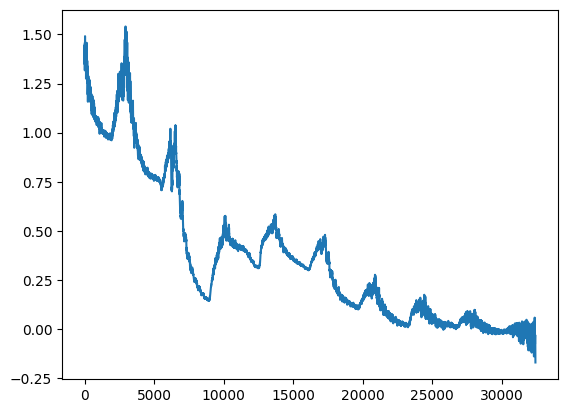

(35428,)


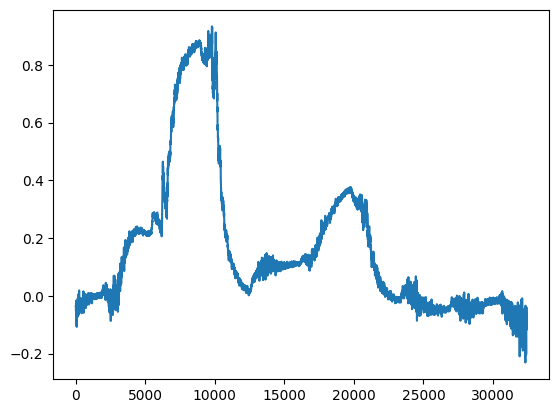

In [321]:
# Check the distribution of all touch points F_z values
F_z_pred = np.sum(F_zi, axis=1)
F_z_virt = []

print(F_zi.shape)
print(F_z_pred.shape)

for i in range(ARRAY_SIZE):
  F_z_virt.append(F_zi[:, i] / F_z_pred)
  
for v in F_z_virt:
  print(v.shape)
  plt.plot(v[3000:])
  # plt.ylim(0, 1)
  plt.show()


In [ ]:
# Create a model that predicts the virtual taxels based on multi-taxel force models
